Importing all the Libraries

In [35]:
import sympy as sp
import numpy as np
import cdd
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import networkx as nx

Plotting the Triangle Graph

(2, <networkx.classes.graph.Graph object at 0x0000024264AF3EB0>)


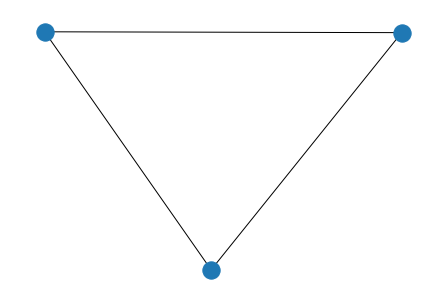

In [36]:
G = nx.Graph()
G.add_nodes_from([1, 2, 3])
G.add_weighted_edges_from([[1, 2, 3], [2, 3, 3], [1, 3, 100]])
pos = nx.spring_layout(G, seed=225)
print(nx.algorithms.approximation.treewidth_min_degree(G))
nx.draw(G, pos)

Creating the Truth Table to extract V-Representation of Correlation Polytope

In [37]:
t_nm = 3 #No. of Vertices for our graph
cor = np.array([[1, 2], [2, 3], [1, 3]]) #list of edges for the graph

def dec_to_bin(num): #converts decimal number to its binary (used for making the truth table)

    s = ''
    for i in range(t_nm):

        s = str(num%2)+s
        num = int(num/2)
    
    return s

A = np.zeros([2**(t_nm), t_nm]) #stores the atomic parts of the truth table

for i in range(2**t_nm):

    bin = dec_to_bin(i)
    for j in range(t_nm):

        A[i][j] = bin[j]

t_cor = len(cor) #No. of edges in the graph
B = np.zeros([2**t_nm, t_cor]) #stores the conjugation parts of the truth table

for j in range(2**t_nm):
    for i, c in enumerate(cor):
        B[j][i] = A[j][c[0]-1]*A[j][c[1]-1]

F = np.concatenate((A, B), axis = 1) #stores the complete truth table
F

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 1., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1.],
       [1., 1., 0., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1.]])

Getting the H representation from the V-representation using cdd

In [38]:
F = np.insert(F, 0, 1, axis = 1)
mat = cdd.Matrix(F) #V-representation of correlation polytope

mat.rep_type = cdd.RepType.GENERATOR

poly = cdd.Polyhedron(mat)

Ineq = np.array(poly.get_inequalities()) #Stores H-representation of the correlation polytope

#Next we extract A and b such that the polytope can be written as S=(x|Ax≤b)
b = Ineq[:, 0]
A = -1*Ineq[:, 1:]

Printing out the H-representation

In [39]:
plist = [] #list of symbolic variables to print the facets 

for i in range(t_nm):
    plist.append(sp.symbols("p"+str(i+1)))

for i in range(t_cor):
    plist.append(sp.symbols("q"+str(cor[i][0])+str(cor[i][1])))

plist = np.array(plist)

Expr_ineq = sp.Matrix(np.matmul(A, plist)) 

for i, j in enumerate(Expr_ineq): #prints the H-representation of the Polytope
    expr = j<=b[i]
    display(expr)

-1.0*q13 <= 0.0

-1.0*q23 <= 0.0

-1.0*q12 <= 0.0

1.0*p1 + 1.0*p2 + 1.0*p3 - 1.0*q12 - 1.0*q13 - 1.0*q23 <= 1.0

1.0*p2 + 1.0*p3 - 1.0*q23 <= 1.0

1.0*p1 + 1.0*p3 - 1.0*q13 <= 1.0

1.0*p1 + 1.0*p2 - 1.0*q12 <= 1.0

-1.0*p1 + 1.0*q13 <= 0.0

-1.0*p1 + 1.0*q12 + 1.0*q13 - 1.0*q23 <= 0.0

-1.0*p1 + 1.0*q12 <= 0.0

-1.0*p2 + 1.0*q23 <= 0.0

-1.0*p2 + 1.0*q12 <= 0.0

-1.0*p2 + 1.0*q12 - 1.0*q13 + 1.0*q23 <= 0.0

-1.0*p3 - 1.0*q12 + 1.0*q13 + 1.0*q23 <= 0.0

-1.0*p3 + 1.0*q13 <= 0.0

-1.0*p3 + 1.0*q23 <= 0.0

Calculating the Volume Ratio Numerically (for the Symmetric Slice)

In [40]:
mrg = np.zeros(t_nm) #stores value of p_i being substituted
t1 = np.linspace(0, 1, 101)[1:100] #Stores the list of value of t (p_i = t) for which the ratio is being calculated

v = [] #stores volumes of local polytope slice
v_ns = [] #stores volumes of the no-signaling slice
lb = [] #stores the number of vertices for the V-representation of the slice

for t in t1:
    c = b.copy()

    for k in range(len(mrg)):
        mrg[k] = t

    for i in range(len(b)):
        for j in range(t_nm):
            c[i] = c[i]-A[i][j]*mrg[j] #substitutes p_i = t in the Inequalities to get a new b (which we call c)
    
    A1 = np.delete(A, [0, 1, 2], axis=1) #removes all p_i

    c = c.reshape(len(c), 1)
    F = np.concatenate((c, -A1), axis = 1) #new H-representation after substitution

    mat = cdd.Matrix(F) #H-representation of sliced polytope
    mat.rep_type = cdd.RepType.INEQUALITY

    poly = cdd.Polyhedron(mat)
    #print(poly.get_generators())

    extr = np.array(poly.get_generators())[:,1:] #Stores the V-representation of the sliced local polytope
    #print(mrg, extr)
    volume = ConvexHull(extr).volume #Volume calculation
    v.append(volume)
    v_ns.append(np.prod([mrg[k]-max(0, 2*mrg[k]-1) for k in range(t_nm)]))
    lb.append(len(extr))

Calculating volume ratio through the Analytical Expressions derived in Paper (for the Symmetric Slice)

In [41]:
t0 = np.linspace(0, 0.33, 10)
v0 = np.array([0.5 for t in t0])

t2 = np.linspace(0.33, 0.5, 100)
v2 = np.array([0.5-((3-1/t)**3)/6 for t in t2])

t3 = np.linspace(0.5, 0.67, 100)
v3 = np.array([0.5-((3-1/(1-t))**3)/6 for t in t3])

t4 = np.linspace(0.67, 1, 10)
v4 = np.array([0.5 for t in t4])

tf = np.concatenate((t0, t2, t3, t4))
vf = np.concatenate((v0, v2, v3, v4))

Plotting the results (for the Symmetric Slice)

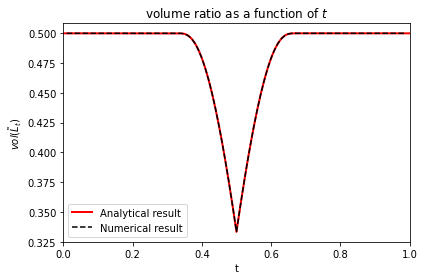

In [42]:
plt.plot(tf, vf, c="red", lw = 2)
plt.plot(t1, np.array(v)/np.array(v_ns), c = "black", ls = "--")
plt.legend(["Analytical result", "Numerical result"])
plt.title("volume ratio as a function of $t$")
plt.xlabel("t")
plt.ylabel("$vol(\~L_t)$")
plt.xlim([0, 1])
plt.tight_layout()
#plt.savefig("plot-K3-sym-vol.png", dpi = 200)

Calculating the Volume Ratio Numerically (for the Skewed Slice)

In [43]:
mrg = np.zeros(t_nm)
t1 = np.linspace(0, 0.5, 101)[1:100]
v = []
v_ns = []
lb = []

for t in t1:
    c = b.copy()

    mrg = [t, t, 0.5-t]

    for i in range(len(b)):
        for j in range(t_nm):
            c[i] = c[i]-A[i][j]*mrg[j]
    
    A1 = np.delete(A, [0, 1, 2], axis=1)

    c = c.reshape(len(c), 1)
    F = np.concatenate((c, -A1), axis = 1)

    mat = cdd.Matrix(F)
    mat.rep_type = cdd.RepType.INEQUALITY

    poly = cdd.Polyhedron(mat)
    #print(poly.get_generators())

    extr = np.array(poly.get_generators())[:,1:]
    #print(mrg, extr)
    volume = ConvexHull(extr).volume
    v.append(volume)
    v_ns.append(t*min(t, 0.5-t)**2)
    lb.append(len(extr))

Calculating volume ratio through the Analytical Expressions derived in Paper (for the Skewed Slice)

In [44]:
x1 = np.linspace(0, 1/6.0, 10)
y1 = 2/3.0*np.ones(10)
x2 = np.linspace(1/6.0+0.001, 1/4.0, 100)
y2 = np.array([2/3.0-((3-1/(2*x2))**3)/6 for x2 in x2])
x3 = np.linspace(1/4.0, 1/2.0, 100)
y3 = np.array([1-3*(1/(2*x3)-1)/6 for x3 in x3])

xf = np.concatenate((x1, x2, x3))
yf = np.concatenate((y1, y2, y3))

Plotting the results (for the Skewed Slice)

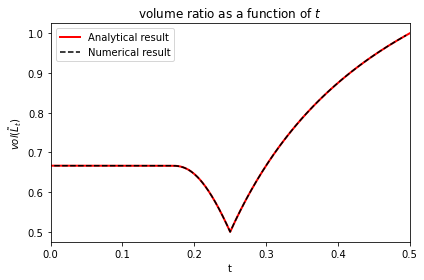

In [45]:
plt.plot(xf, yf, c = "red", lw = 2)
plt.plot(t1, np.array(v)/np.array(v_ns) , c = "black", ls = "--")
plt.legend(["Analytical result", "Numerical result"])
plt.title("volume ratio as a function of $t$")
plt.xlabel("t")
plt.ylabel("$vol(\~L_t)$")
plt.xlim([0, 0.5])
plt.tight_layout()
plt.savefig("plot-K3-skew-vol.png", dpi = 200)